In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from keras.models import load_model
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Initialization of variables
look_back i.e number of close prices to be given as input 
forward_days i.e number of days for which close prices are to be predicted in future 
num_periods i.e the number of batches the entire data is divided into

In [2]:
look_back = 40
forward_days = 10
num_periods = 20

# Import Data 

In [3]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2019-04-06,5036.79,5205.82,4992.22,5059.82,16929795194,89212733450
1,2019-04-05,4922.81,5053.51,4919.49,5036.68,16837325387,88796118650
2,2019-04-04,4971.31,5063.16,4836.79,4922.80,18251810240,86778727821
3,2019-04-03,4879.96,5307.00,4876.62,4973.02,22899891582,87655288145
4,2019-04-02,4156.92,4905.95,4155.32,4879.88,21315047816,85986009273


In [4]:
df = pd.DataFrame(bitcoin_market_info[['Close','Date']])
df.set_index('Date', inplace=True)
df = df.sort_index()

In [5]:
len(df)

2170

# Data Visualization

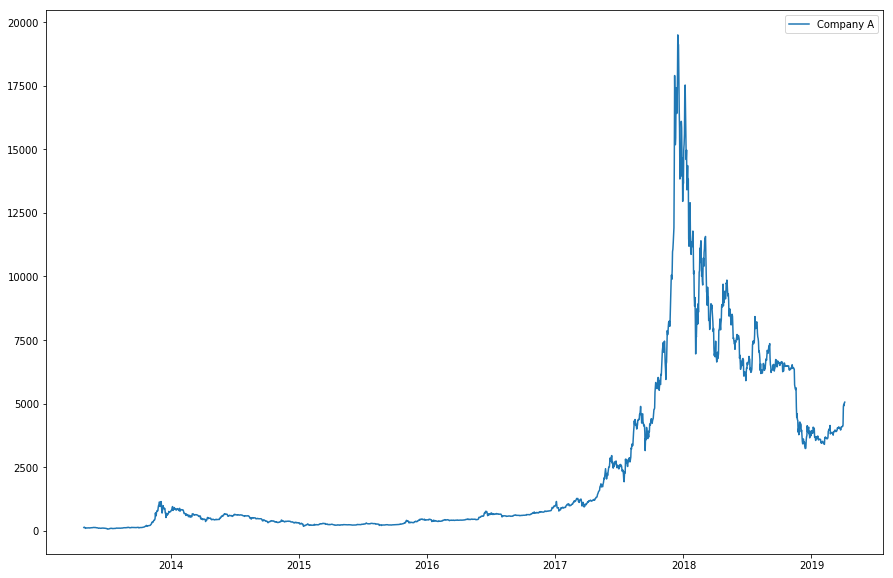

In [6]:
plt.figure(figsize = (15,10))
plt.plot(df, label='Company A')
plt.legend(loc='best')
plt.show()

# Data Normalization

In [7]:
data = df.values.reshape(df.shape[0],1)
data[:5]

array([[134.21],
       [144.54],
       [139.  ],
       [116.99],
       [105.21]])

In [9]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
data = scl.fit_transform(data)
data[:5]

array([[0.00338567],
       [0.00391735],
       [0.0036322 ],
       [0.00249936],
       [0.00189305]])

# Split the data in train/test for LSTM

We want to predict the n days ahead (foward_days) having as input the m past observed days (look_back). So, if we have an input of m past days, the network output will be the prediction for the n next days. We will split the data in Train and Test. The test will be composed of k periods (num_periods), in which every period is a series of n days prediction.

In [10]:
split_point = len(data) - num_periods*forward_days
test_data = data[split_point-look_back:]
train_data = data[:split_point]

In [11]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [12]:
X_test,y_test = processData(test_data,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(train_data,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(1536, 40, 1)
(385, 40, 1)
(20, 40, 1)
(1536, 10)
(385, 10)
(20, 10)


# Training LSTM

In [18]:
model = load_model('./LSTM_CP.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 20,430
Trainable params: 20,430
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 50

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dropout(0.25))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

#uncomment the below line to freshly train the model
history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Train on 1536 samples, validate on 385 samples
Epoch 1/50
 - 67s - loss: 0.0065 - val_loss: 0.0013
Epoch 2/50
 - 63s - loss: 0.0032 - val_loss: 8.4387e-04
Epoch 3/50
 - 74s - loss: 0.0030 - val_loss: 0.0016
Epoch 4/50
 - 67s - loss: 0.0024 - val_loss: 8.2049e-04
Epoch 5/50
 - 65s - loss: 0.0023 - val_loss: 0.0012
Epoch 6/50
 - -7s - loss: 0.0023 - val_loss: 6.9337e-04
Epoch 7/50
 - 70s - loss: 0.0021 - val_loss: 7.2177e-04
Epoch 8/50
 - 65s - loss: 0.0019 - val_loss: 0.0012
Epoch 9/50
 - 63s - loss: 0.0021 - val_loss: 7.8808e-04
Epoch 10/50
 - 63s - loss: 0.0019 - val_loss: 6.8800e-04
Epoch 11/50
 - 62s - loss: 0.0018 - val_loss: 6.8273e-04
Epoch 12/50
 - 62s - loss: 0.0020 - val_loss: 6.8057e-04
Epoch 13/50
 - 62s - loss: 0.0020 - val_loss: 5.9391e-04
Epoch 14/50
 - 62s - loss: 0.0018 - val_loss: 6.3441e-04
Epoch 15/50
 - 63s - loss: 0.0018 - val_loss: 5.7580e-04
Epoch 16/50
 - 62s - loss: 0.0019 - val_loss: 6.1937e-04
Epoch 17/50
 - 63s - loss: 0.0018 - val_loss: 6.2898e-04
Epoch 18/

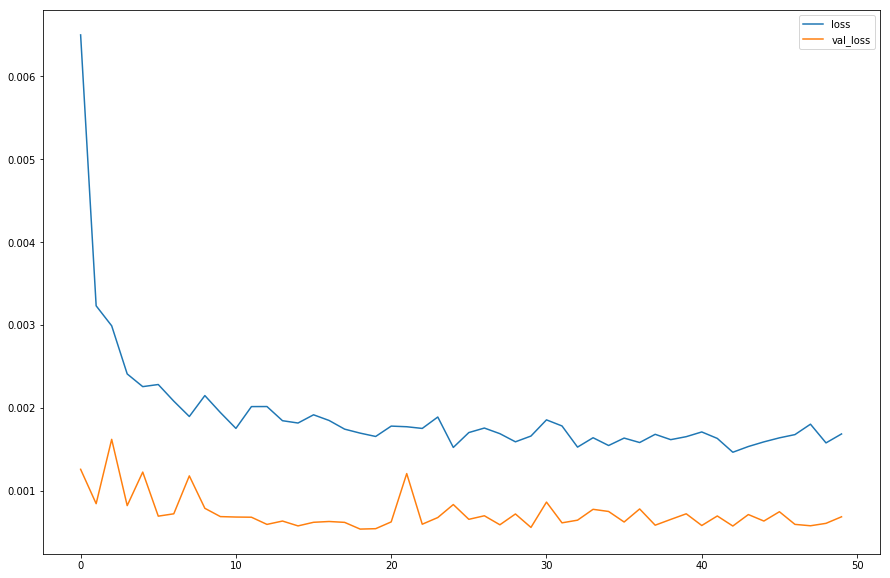

In [22]:
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [23]:
#Saving the model
file_name = './LSTM_CP.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `./LSTM_close_price.h5` to disk


In [24]:
Xt = model.predict(X_test)

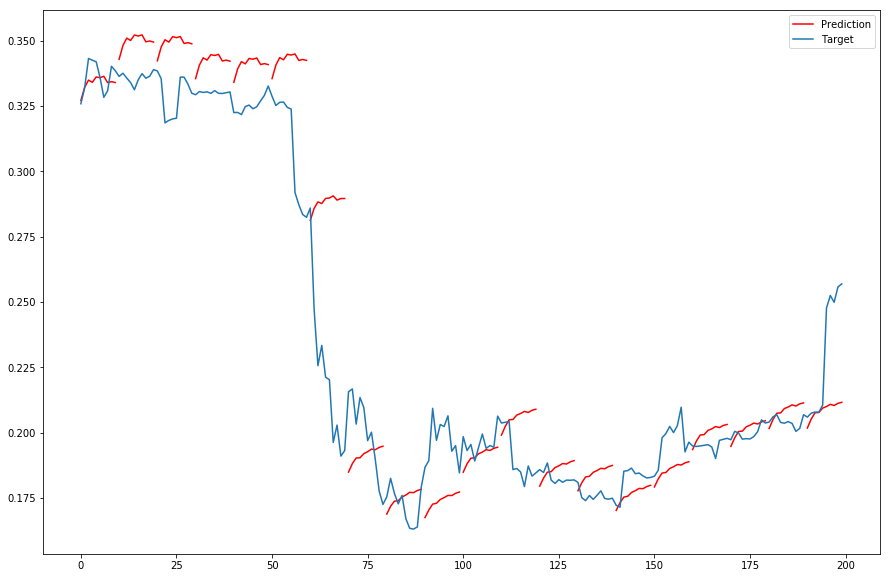

In [25]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
  
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

# Results

In [26]:
#Mean absolute error
mae_values=[]
mae_days =[]

for i,v in enumerate(Xt):
    prediction = scl.inverse_transform(np.array(np.reshape(Xt[i], (-1, 1))))
    actual = scl.inverse_transform(np.array(np.reshape(y_test[i], (-1, 1))))
    predictions = np.array([i[0] for i in prediction])
    actuals = np.array([i[0] for i in actual])
    print("Predicted best day:"+ str(np.where(predictions==min(predictions))[0][0])+"----Actual best day:"+ str(np.where(actuals==min(actuals))[0][0]))
    mae = (abs(predictions - actuals)).mean()
    mae_days.append(abs(np.where(prediction==min(prediction))[0][0]-np.where(actual==min(actual))[0][0]))
    mae_values.append(mae)

Predicted best day:0----Actual best day:0
Predicted best day:0----Actual best day:4
Predicted best day:0----Actual best day:2
Predicted best day:0----Actual best day:0
Predicted best day:0----Actual best day:2
Predicted best day:0----Actual best day:9
Predicted best day:0----Actual best day:8
Predicted best day:0----Actual best day:9
Predicted best day:0----Actual best day:7
Predicted best day:0----Actual best day:9
Predicted best day:0----Actual best day:3
Predicted best day:0----Actual best day:6
Predicted best day:0----Actual best day:4
Predicted best day:0----Actual best day:2
Predicted best day:0----Actual best day:1
Predicted best day:0----Actual best day:0
Predicted best day:0----Actual best day:6
Predicted best day:0----Actual best day:0
Predicted best day:0----Actual best day:7
Predicted best day:0----Actual best day:0


In [27]:
print("MAE: "+ str(np.mean(mae_values)))
print("MAE_days: "+ str(np.mean(mae_days)))

MAE: 0.015031027242542655
MAE_days: 3.95
